<a href="https://colab.research.google.com/github/carlosperez1997/CaixabankTech_DS/blob/main/probabilistic_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Hierarchical Linear Regression
## Probabilistic Inference in Machine Learning Final Project
### Professor: Lorenzo Capello
### Students: Carlos Pérez, Harry Morley, Mox Ballo

# Hierarchical regression with numpyro

- How to obtain probability distributions using MCMC algorithms.
- Using numpyro to compute prior and posterior in Bayesian framework.
- What is Hierarchical model clustering. Definition of plate and overall conceptual model
- Case study: Hierarchical Bayesian Linear Regression


## Drawing unknown probability distributions




### Metropolis-Hastings

In [ ]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
from matplotlib.animation import FFMpegWriter

In [ ]:
class DonutPDF:
    def __init__(self, radius=3, sigma2=0.05):
        self.radius = radius
        self.sigma2 = sigma2

    def __call__(self, x):
        r = np.linalg.norm(x)
        return np.exp(-((r - self.radius) ** 2) / self.sigma2)

In [ ]:
def metropolis(target, initial, proposal, iterations=100_000):
    samples = [initial()]

    for _ in range(iterations):
        current = samples[-1]
        proposed = proposal(current)

        #print('Current:', current)
        #print('Proposed:', proposed)
        #print('Target proposed:', target(proposed))
        #print('Target current:', target(current))

        if np.random.random() < target(proposed) / target(current):
            samples.append(proposed)
        else:
            samples.append(current)

    return samples


class NormalProposal:
    def __init__(self, scale):
        self.scale = scale

    def __call__(self, sample):
        jump = np.random.normal(scale=self.scale, size=sample.shape)
        return sample + jump

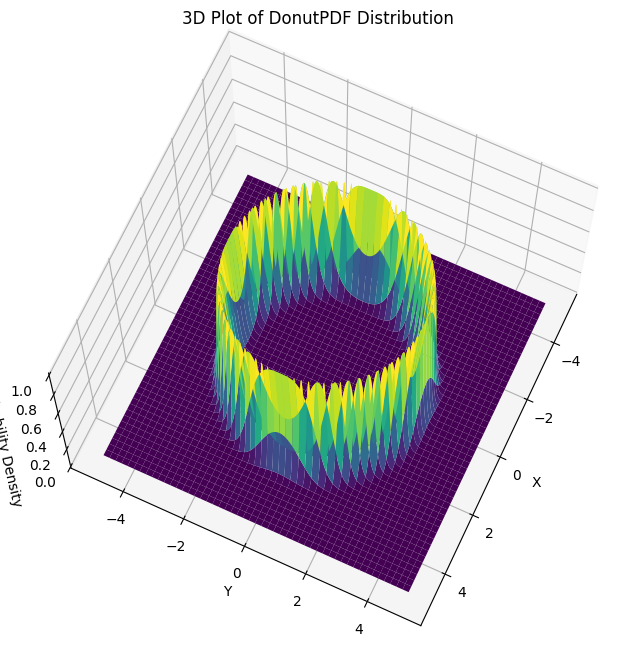

In [ ]:
donut_pdf = DonutPDF()

# Generate data for plotting
x = np.linspace(-5, 5, 2_000)
y = np.linspace(-5, 5, 2_000)
X, Y = np.meshgrid(x, y)
Z = np.array([donut_pdf([x, y]) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Probability Density')
ax.set_title('3D Plot of DonutPDF Distribution')
ax.view_init(elev=70, azim=25)

plt.show()

In [ ]:
target = DonutPDF()
samples05 = np.array(metropolis(target, lambda: np.array([3, 0]), NormalProposal(0.05)))
samples1 = np.array(metropolis(target, lambda: np.array([3, 0]), NormalProposal(1)))

In [ ]:
def plot_donut_metropolis(i):
    f, ax = plt.subplots(figsize=(10, 5), ncols=2)

    f.suptitle(f"Metropolis-Hastings Sampling for DonutPDF at iteration = {i}", fontsize=16)  # Global title for the whole figure
    ax[0].tick_params(axis="both", which="major", labelsize=14)
    ax[1].tick_params(axis="both", which="major", labelsize=14)

    points = np.linspace(-4, 4, 301)
    x = np.tile(points, len(points))
    y = np.repeat(points, len(points))

    z = np.exp(np.apply_along_axis(target, 1, np.column_stack([x, y])))

    ax[0].contour(
        points,
        points,
        z.reshape(len(points), len(points)),
        cmap="plasma",
        alpha=0.3,
        levels=5,
    )

    ax[1].contour(
        points,
        points,
        z.reshape(len(points), len(points)),
        cmap="plasma",
        alpha=0.3,
        levels=5,
    )

    (traj05,) = ax[0].plot([], [])
    (traj1,) = ax[1].plot([], [])

    title05 = ax[0].set_title("(Proposal std=0.05)", fontsize=16)
    title1 = ax[1].set_title("(Proposal std=1)", fontsize=16)

    traj05.set_data(*(samples05[: i + 1].T))
    traj1.set_data(*(samples1[: i + 1].T))

    accept05 = 1 - (samples05[1 : i + 1] == samples05[:i]).all(axis=1).mean()
    accept1 = 1 - (samples1[1 : i + 1] == samples1[:i]).all(axis=1).mean()
    ax[0].text(
        0.5, 0.97, f"Acceptance rate: {accept05 * 100:.1f}%", ha='center', va='top', transform=ax[0].transAxes, fontsize=14
    )
    ax[1].text(
        0.5, 0.97, f"Acceptance rate: {accept1 * 100:.1f}%", ha='center', va='top', transform=ax[1].transAxes, fontsize=14
    )
    plt.show()

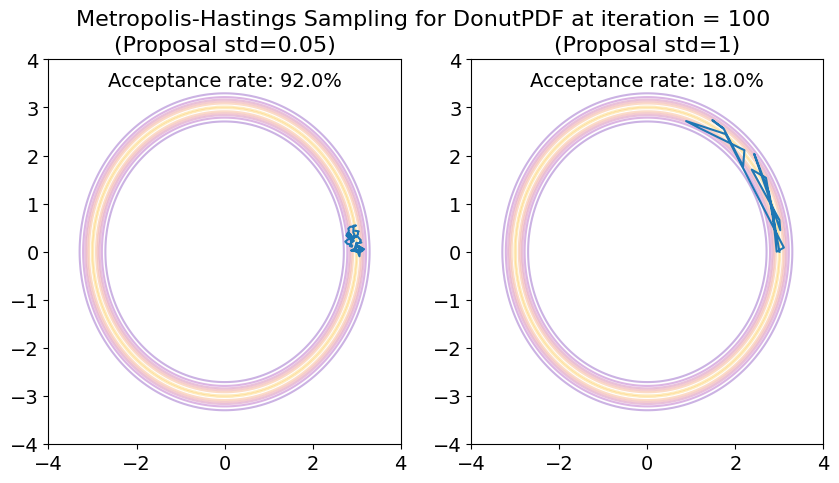

In [ ]:
plot_donut_metropolis(100)

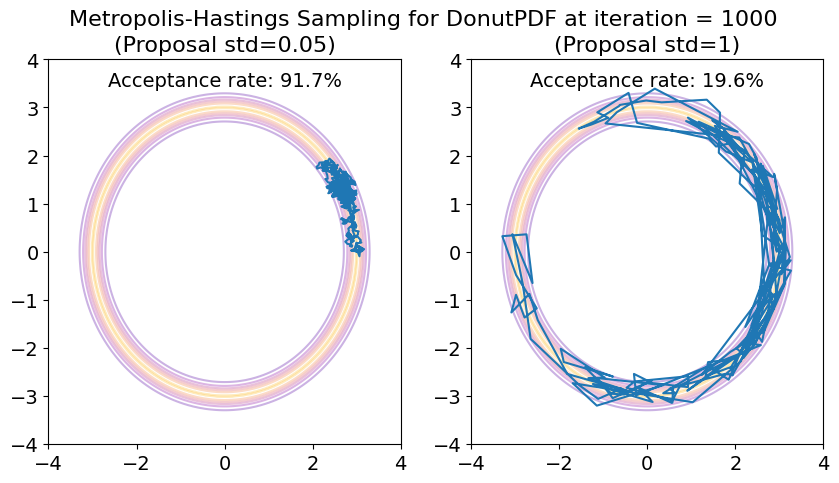

In [ ]:
plot_donut_metropolis(1000)

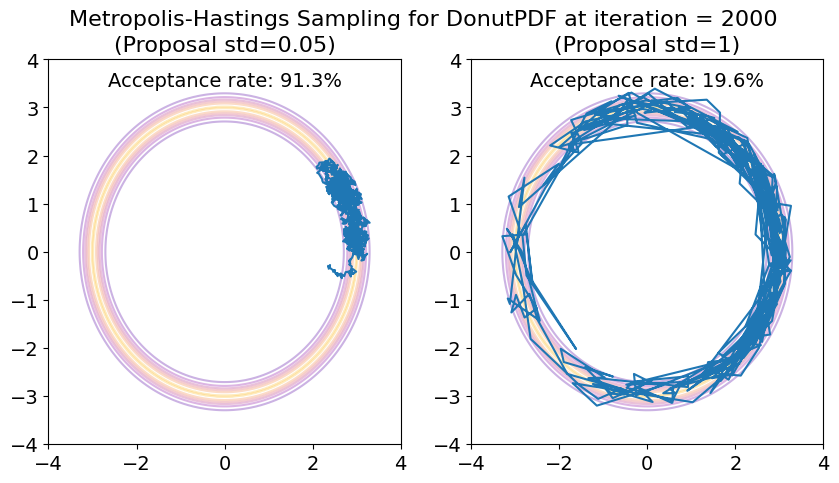

In [ ]:
plot_donut_metropolis(2000)

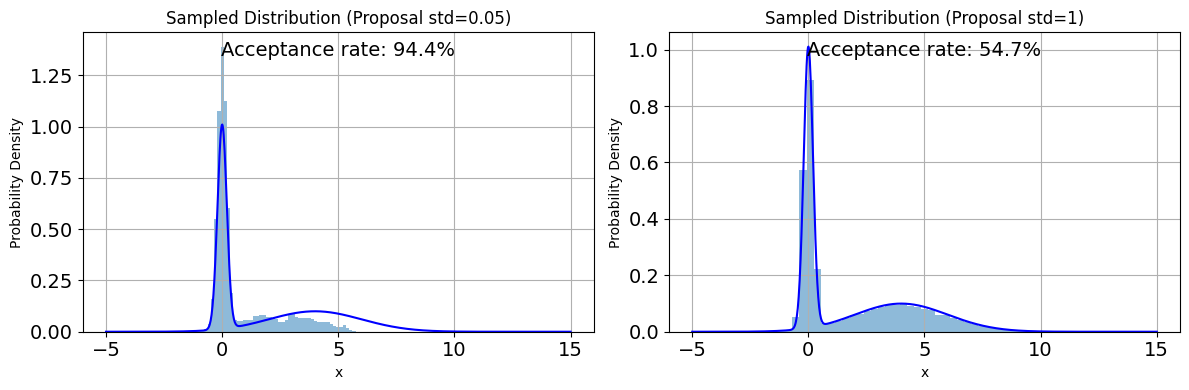

In [ ]:
class BimodalNormalPDF:
    def __init__(self, mean1=0, mean2=4, std1=0.2, std2=2):
        self.mean1 = mean1
        self.mean2 = mean2
        self.std1 = std1
        self.std2 = std2

    def __call__(self, x):
        x = np.asarray(x)
        prob1 = (1 / (self.std1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - self.mean1) / self.std1) ** 2)
        prob2 = (1 / (self.std2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - self.mean2) / self.std2) ** 2)
        return 0.5 * prob1 + 0.5 * prob2  # Equal weighting for both modes

# Example usage:
target = BimodalNormalPDF()
samples_05 = np.array(metropolis(target, lambda: np.array([2]), NormalProposal(0.05)))
samples_1 = np.array(metropolis(target, lambda: np.array([2]), NormalProposal(1)))

# Generate x values for plotting
x_values = np.linspace(-5, 15, 1000)

# Evaluate the true distribution at x values
true_distribution = target(x_values)

# Create subplots
fig, axs = plt.subplots(figsize=(12, 4), ncols=2)
axs[0].tick_params(axis="both", which="major", labelsize=14)
axs[1].tick_params(axis="both", which="major", labelsize=14)

# Plot true distribution on the first subplot
axs[0].plot(x_values, true_distribution, label='True Distribution', color='blue')

# Plot histogram of samples on the first subplot
axs[0].hist(samples_05, bins=50, alpha=0.5, label='Proposal std=0.05', density=True)
axs[0].set_title('Sampled Distribution (Proposal std=0.05)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('Probability Density')
#axs[0].legend()
axs[0].grid(True)

# Plot true distribution on the second subplot
axs[1].plot(x_values, true_distribution, label='True Distribution', color='blue')

# Plot histogram of samples on the second subplot
axs[1].hist(samples_1, bins=50, alpha=0.5, label='Proposal std=1', density=True)
axs[1].set_title('Sampled Distribution (Proposal std=1)')
axs[1].set_xlabel('x')
axs[1].set_ylabel('Probability Density')
#axs[1].legend()
axs[1].grid(True)

i = len(samples05)-1
accept05 = 1 - (samples_05[1 : i + 1] == samples_05[:i]).all(axis=1).mean()
accept1 = 1 - (samples_1[1 : i + 1] == samples_1[:i]).all(axis=1).mean()
axs[0].text(
    0.5, 0.97, f"Acceptance rate: {accept05 * 100:.1f}%", ha='center', va='top', transform=axs[0].transAxes, fontsize=14
)
axs[1].text(
    0.5, 0.97, f"Acceptance rate: {accept1 * 100:.1f}%", ha='center', va='top', transform=axs[1].transAxes, fontsize=14
)

plt.tight_layout()
plt.show()


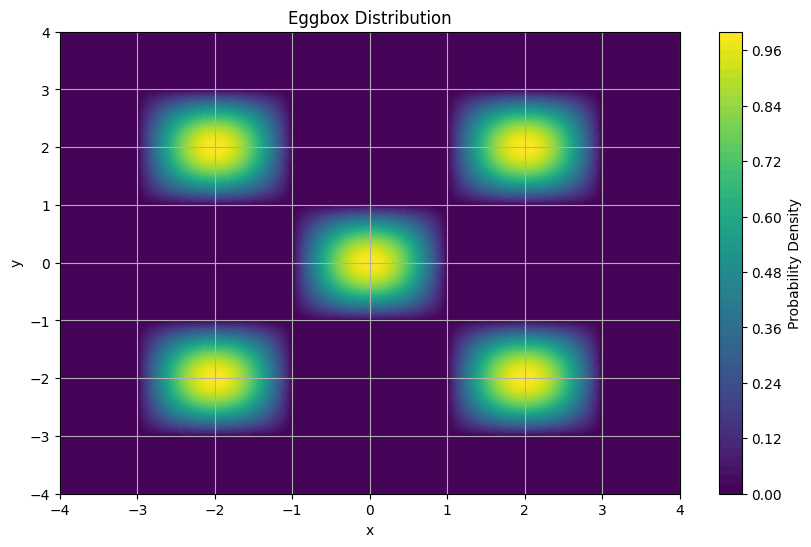

In [ ]:
class EggboxPDF:
    def __init__(self, xlim = 3, ylim = 3):
        self.xlim = xlim
        self.ylim = ylim

    def __call__(self, x):

        try:
            pdf = np.cos(0.5 * np.pi * x[0]) * np.cos(0.5 * np.pi * x[1])
            pdf[np.where(pdf < 0)] = 0

            # Set limits
            pdf[np.where(x[0] > self.xlim)] = 0
            pdf[np.where(x[0] < -self.xlim)] = 0
            pdf[np.where(x[1] > self.xlim)] = 0
            pdf[np.where(x[1] < -self.xlim)] = 0
        except:
            if x[0] > 3 or x[0] < -3 or x[1] > 3 or x[1] < -3:
                return 0
            pdf = np.cos(0.5 * np.pi * x[0]) * np.cos(0.5 * np.pi * x[1])
            if pdf < 0:
                pdf = 0

        return pdf

# Example usage:
eggbox_pdf = EggboxPDF()

# Generate x, y values for plotting
x_values = np.linspace(-4, 4, 200)
y_values = np.linspace(-4, 4, 200)
X, Y = np.meshgrid(x_values, y_values)
Z = eggbox_pdf([X, Y])

# Plot the Rosenbrock distribution
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Probability Density')
plt.title('Eggbox Distribution')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

<ipython-input-11-6f10671d5d92>:10: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  pdf[np.where(pdf < 0)] = 0


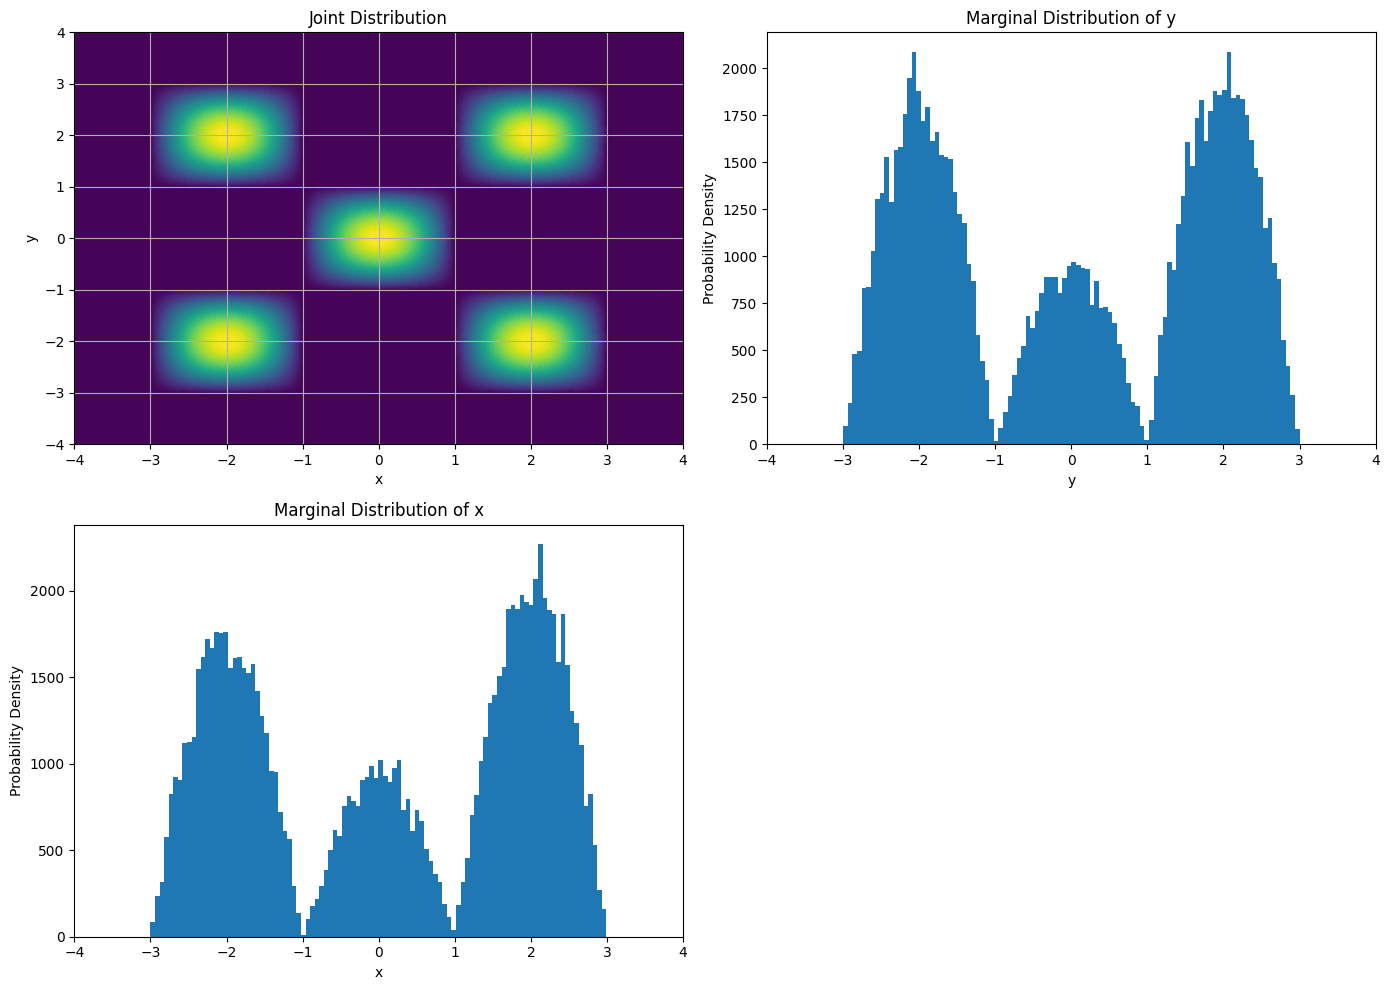

In [ ]:
target = EggboxPDF()
samples = np.array(metropolis(target, lambda: np.array([-3, 3]), NormalProposal(1)))

# Generate x, y values for plotting
x_values = np.linspace(-4, 4, 200)
y_values = np.linspace(-4, 4, 200)
X, Y = np.meshgrid(x_values, y_values)
Z = eggbox_pdf([X, Y])

"""# Plot histogram of samples
#plt.scatter(samples05[:, 0], samples05[:, 1], alpha=0.5, label='Proposal std=0.05')
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.scatter(samples[:, 0], samples1[:, 1], alpha=0.2, label='Proposal std=1')
plt.title('Comparison of True Distribution and Sampled Data')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()"""

# Calculate marginal distributions
marginal_x = np.sum(Z, axis=0)
marginal_y = np.sum(Z, axis=1)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot joint distribution
axs[0, 0].contourf(X, Y, Z, levels=50, cmap='viridis')
axs[0, 0].set_title('Joint Distribution')
axs[0, 0].set_xlim([-4, 4])
axs[0, 0].set_ylim([-4, 4])
axs[0, 0].set_xlabel('x')
axs[0, 0].set_ylabel('y')
axs[0, 0].grid(True)

# Plot marginal distribution of x
#axs[1, 0].plot(x_values, marginal_x)
axs[1, 0].hist(samples[:, 0], bins=100)
axs[1, 0].set_xlim([-4, 4])  # Set the x-axis limits here
axs[1, 0].set_title('Marginal Distribution of x')
axs[1, 0].set_xlabel('x')
axs[1, 0].set_ylabel('Probability Density')

# Plot marginal distribution of y
#axs[0, 1].plot(y_values, marginal_y)
axs[0, 1].hist(samples[:, 1], bins=100)
axs[0, 1].set_xlim([-4, 4])  # Set the x-axis limits here
axs[0, 1].set_title('Marginal Distribution of y')
axs[0, 1].set_xlabel('y')
axs[0, 1].set_ylabel('Probability Density')

# Remove empty subplot
fig.delaxes(axs[1,1])

plt.tight_layout()
plt.show()

### Hamiltonian Monte Carlo

In [ ]:
def leapfrog(q0, p0, target, L, step_size):
    q = q0.copy().astype(float)
    p = p0.copy().astype(float)
    for i in range(L):
        p += target.grad_log_density(q) * step_size / 2
        q += p * step_size
        p += target.grad_log_density(q) * step_size / 2
    return q, p


def leapfrog_traj(q0, p0, target, L, step_size):
    q = q0.copy()
    p = p0.copy()
    traj = [q.copy()]

    for i in range(L):
        p += target.grad_log_density(q) * step_size / 2
        q += p * step_size
        p += target.grad_log_density(q) * step_size / 2
        traj.append(q.copy())

    return q, p, traj


def hmc(target, initial, iterations=10_000, L=50, step_size=0.1):
    samples = [initial()]

    for i in range(iterations):
        q0 = samples[-1]
        p0 = np.random.standard_normal(size=q0.size)

        q_star, p_star = leapfrog(q0, p0, target, L, step_size)

        h0 = -target.log_density(q0) + (p0 * p0).sum() / 2
        h = -target.log_density(q_star) + (p_star * p_star).sum() / 2
        log_accept_ratio = h0 - h

        if np.random.random() < np.exp(log_accept_ratio):
            samples.append(q_star)
        else:
            samples.append(q0)

    return samples

In [ ]:
class DonutPDF:
    def __init__(self, radius=3, sigma2=0.05):
        self.radius = radius
        self.sigma2 = sigma2

    def log_density(self, x):
        r = np.linalg.norm(x)
        return -((r - self.radius) ** 2) / self.sigma2

    def grad_log_density(self, x):
        r = np.linalg.norm(x)
        if r == 0:
            return np.zeros_like(x)
        return 2 * x * (self.radius / r - 1) / self.sigma2

hmc_samples = hmc(DonutPDF(), lambda: np.array([3, 0.0]))

In [ ]:
def compare_algos(i, hmc_samples, samples1, samples05):
    f, ax = plt.subplots(ncols=3, figsize=(14, 5))

    hmc_samples = np.array(hmc_samples)

    points = np.linspace(-4, 4, 101)
    x = np.tile(points, len(points))
    y = np.repeat(points, len(points))

    donut = DonutPDF()
    z = np.exp(np.apply_along_axis(donut.log_density, 1, np.column_stack([x, y])))

    for a in ax:
        a.contour(
            points,
            points,
            z.reshape(len(points), len(points)),
            cmap="plasma",
            alpha=0.1,
        )

    (mcmc05_scat,) = ax[0].plot([], [], ".", alpha=0.2, ms=10)
    (mcmc1_scat,) = ax[1].plot([], [], ".", alpha=0.2, ms=10)
    (hmc_scat,) = ax[2].plot([], [], ".", alpha=0.2, ms=10)

    title05 = ax[0].set_title(
        "RW-Metropolis - scale = 0.05\n# samples: 0\nAccept rate: N/A", fontsize=18
    )
    title1 = ax[1].set_title(
        "RW-Metropolis - scale = 1.0\n# samples: 0\nAccept rate: N/A", fontsize=18
    )
    title_hmc = ax[2].set_title("HMC\n# samples: 0\nAccept rate: N/A", fontsize=18)

    for a in ax:
        a.set_xlim(-4, 4)
        a.set_ylim(-4, 4)

    f.tight_layout(pad=2)

    mcmc05_scat.set_data(*samples05[: i + 1].T)
    mcmc1_scat.set_data(*samples1[: i + 1].T)
    hmc_scat.set_data(*hmc_samples[: i + 1].T)

    accept05 = 1 - (samples05[1 : i + 1] == samples05[:i]).all(axis=1).mean()
    accept1 = 1 - (samples1[1 : i + 1] == samples1[:i]).all(axis=1).mean()
    accept_hmc = 1 - (hmc_samples[1 : i + 1] == hmc_samples[:i]).all(axis=1).mean()

    title05.set_text(
        f"RW-Metropolis - scale = 0.05\n# samples: {i}\nAccept rate: {accept05 * 100:.2f}%"
    )
    title1.set_text(
        f"RW-Metropolis - scale = 1.0\n# samples: {i}\nAccept rate: {accept1 * 100:.2f}%"
    )
    title_hmc.set_text(
        f"HMC\n# samples: {i}\nAccept rate: {accept_hmc * 100:.2f}%"
    )

    plt.show()

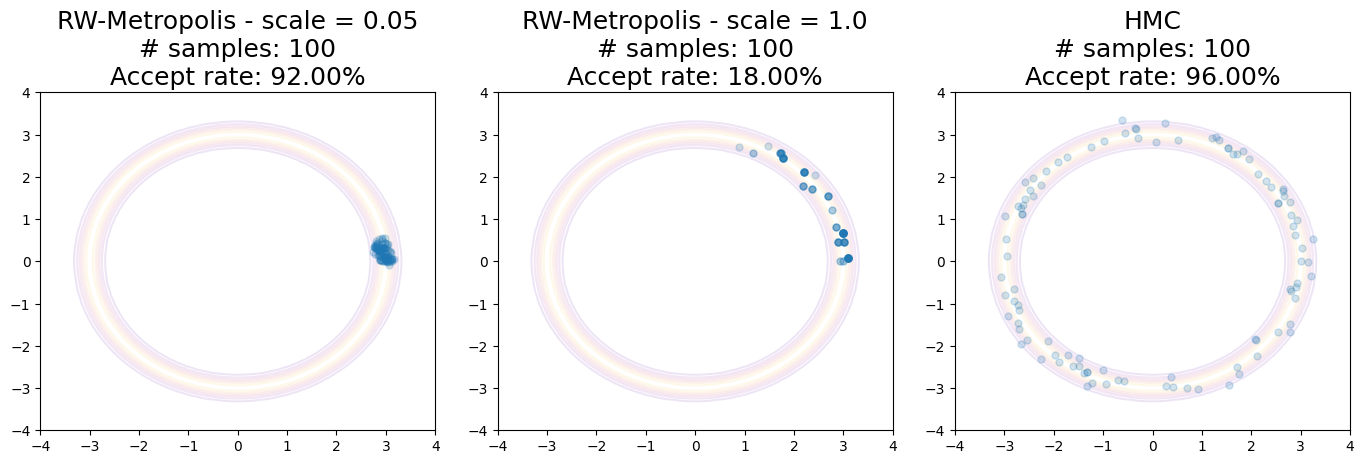

In [ ]:
compare_algos(100, hmc_samples, samples1, samples05)

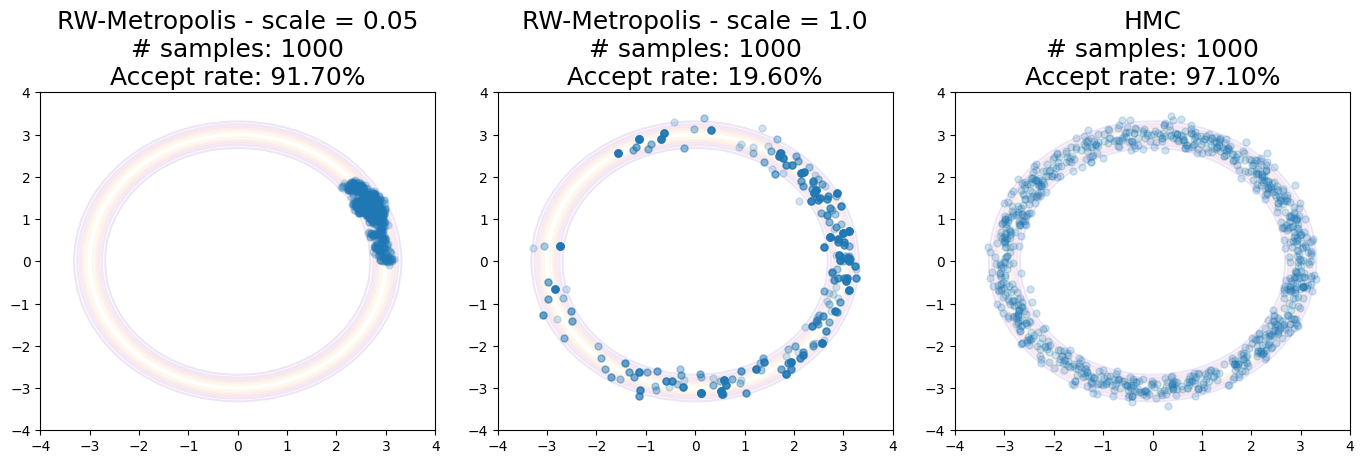

In [ ]:
compare_algos(1000, hmc_samples, samples1, samples05)

In [ ]:
class BimodalNormalPDF:
    def __init__(self, mean1=0, mean2=4, std1=0.2, std2=2):
        self.mean1 = mean1
        self.mean2 = mean2
        self.std1 = std1
        self.std2 = std2

    def __call__(self, x):
        x = np.asarray(x)
        prob1 = (1 / (self.std1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - self.mean1) / self.std1) ** 2)
        prob2 = (1 / (self.std2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - self.mean2) / self.std2) ** 2)
        return 0.5 * prob1 + 0.5 * prob2  # Equal weighting for both modes

    def log_density(self, x):
        prob = self.__call__(x)
        return np.log(prob)

    def grad_log_density(self, x):
        x = np.asarray(x)
        pdf1 = (1 / (self.std1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - self.mean1) / self.std1) ** 2)
        pdf2 = (1 / (self.std2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - self.mean2) / self.std2) ** 2)

        # Weighted gradient
        grad1 = -((x - self.mean1) / (self.std1 ** 2)) * pdf1
        grad2 = -((x - self.mean2) / (self.std2 ** 2)) * pdf2

        return 0.5 * grad1 + 0.5 * grad2

In [ ]:
target = BimodalNormalPDF()
samples_05 = np.array(metropolis(target, lambda: np.array([3]), NormalProposal(0.05)))
samples_1 = np.array(metropolis(target, lambda: np.array([3]), NormalProposal(1)))
hmc_samples = np.array(hmc(target, lambda: np.array([3])))

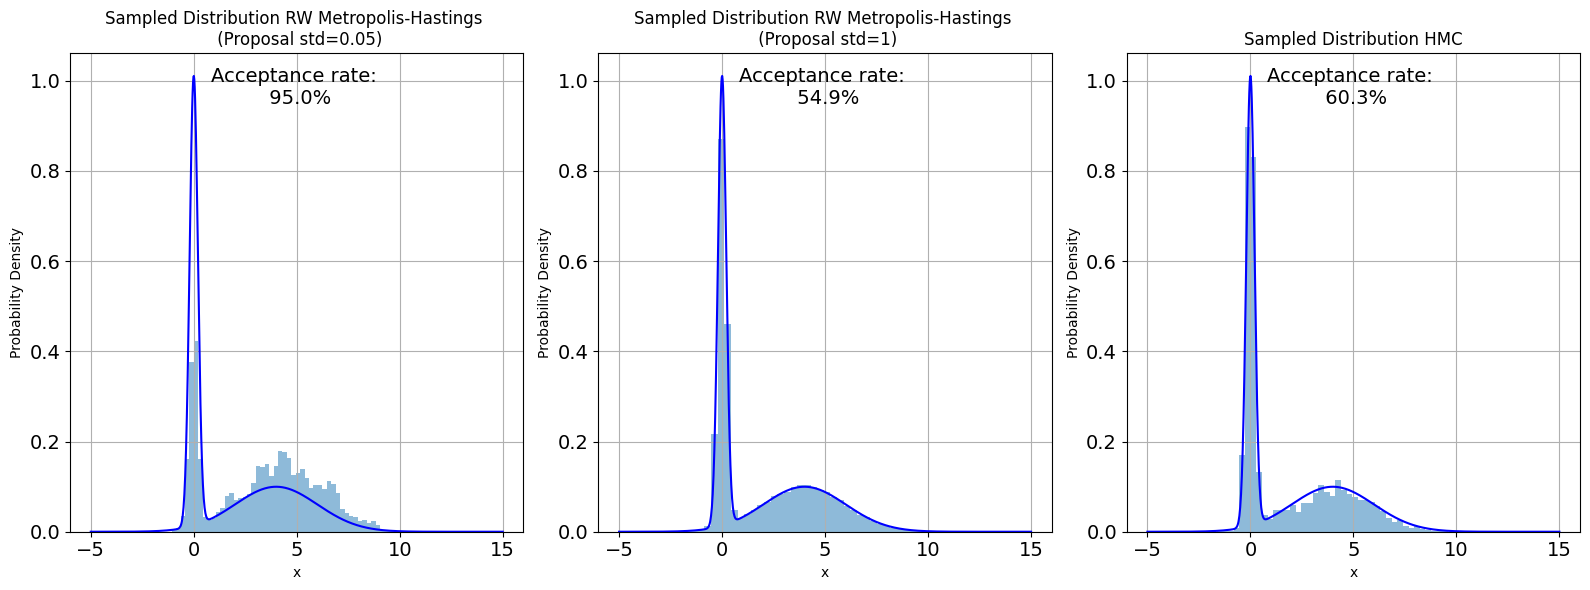

In [ ]:
# Generate x values for plotting
x_values = np.linspace(-5, 15, 1000)

# Evaluate the true distribution at x values
true_distribution = target(x_values)

def helper_plot(ax, values, title, accept):
    ax.tick_params(axis="both", which="major", labelsize=14)
    ax.plot(x_values, true_distribution, label='True Distribution', color='blue')
    # Plot histogram of samples on the first subplot
    ax.hist(values, bins=50, alpha=0.5, density=True)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('Probability Density')
    ax.grid(True)

    ax.text(
        0.5, 0.97, f"Acceptance rate: \n {accept * 100:.1f}%", ha='center', va='top', transform=ax.transAxes, fontsize=14
    )

    return ax

# Create subplots
fig, axs = plt.subplots(figsize=(16, 6), ncols=3)

i = min(len(samples_05), len(hmc_samples))-1
accept05 = 1 - (samples_05[1 : i + 1] == samples_05[:i]).all(axis=1).mean()
accept1 = 1 - (samples_1[1 : i + 1] == samples_1[:i]).all(axis=1).mean()
accept2 = 1 - (hmc_samples[1 : i + 1] == hmc_samples[:i]).all(axis=1).mean()

axs[0] = helper_plot(axs[0], samples_05, 'Sampled Distribution RW Metropolis-Hastings \n (Proposal std=0.05)', accept05)
axs[1] = helper_plot(axs[1], samples_1, 'Sampled Distribution RW Metropolis-Hastings \n (Proposal std=1)', accept1)
axs[2] = helper_plot(axs[2], hmc_samples, 'Sampled Distribution HMC', accept2)

plt.tight_layout()
plt.show()

# Numpyro

In [ ]:
!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 2.6 MB/s eta 0:00:00


In [ ]:
import numpyro
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
import arviz as az

import numpy as np

import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D

In [ ]:
## make two data arrays representing observations
## of six home sales
salesPrice = [160, 220, 190, 250, 290, 240]
sqFootage = [960, 1285, 1350, 1600, 1850, 1900]

## make tree height an array - numpyro will NOT accept a pandas series as input
salesPriceData = jnp.array(salesPrice)
sqFootageData = jnp.array(sqFootage)

## define the graphical/statistical model as a Python function
def salesPriceModel(salesPriceArray, sqFootageArray, numObs):
    alpha = numpyro.sample('alpha', dist.Uniform(-100, 175))
    beta = numpyro.sample('beta', dist.Normal(0.12, 0.08))
    sigma = numpyro.sample('sigma', dist.Gamma(4, 0.1))
    with numpyro.plate('observation', numObs):
        mu = numpyro.deterministic("mu", alpha + beta * sqFootageArray)
        y = numpyro.sample('x', dist.Normal(loc = mu, scale = sigma),
                           obs=salesPriceArray)

# ## computationally get posterior distribution
mcmc = MCMC(NUTS(salesPriceModel), num_warmup=2000, num_samples=5000)
rng_key = random.PRNGKey(seed = 111) ## so you and I get same results
mcmc.run(rng_key, salesPriceArray = salesPriceData,
         sqFootageArray = sqFootageData,
         numObs = len(salesPriceData)) ## get representative sample of posterior

sample: 100%|██████████| 7000/7000 [00:13<00:00, 509.18it/s, 15 steps of size 9.19e-02. acc. prob=0.96]


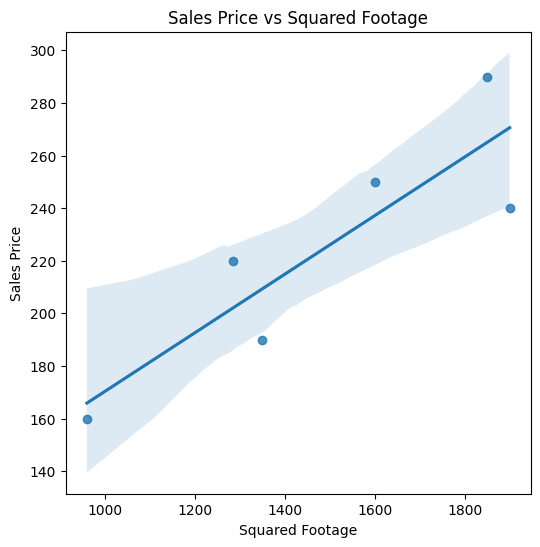

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
sns.regplot(x=sqFootage, y=salesPrice, ax=ax)
ax.set_xlabel('Squared Footage')
ax.set_ylabel('Sales Price')
ax.set_title('Sales Price vs Squared Footage')
plt.show()

In [ ]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     54.48     48.58     55.64    -24.43    139.59   1350.36      1.00
      beta      0.11      0.03      0.11      0.06      0.16   1340.37      1.00
     sigma     31.08     10.16     29.17     15.81     45.54   1353.86      1.00

Number of divergences: 0


In [ ]:
## get samples into xarray
drawsDS = az.from_numpyro(mcmc).posterior
drawsDS

<xarray.Dataset>
Dimensions:   (chain: 1, draw: 5000, mu_dim_0: 6)
Coordinates:
  * chain     (chain) int64 0
  * draw      (draw) int64 0 1 2 3 4 5 6 ... 4993 4994 4995 4996 4997 4998 4999
  * mu_dim_0  (mu_dim_0) int64 0 1 2 3 4 5
Data variables:
    alpha     (chain, draw) float32 63.42 61.73 22.29 6.85 ... 43.91 53.38 58.0
    beta      (chain, draw) float32 0.1124 0.1052 0.1299 ... 0.1058 0.1109
    mu        (chain, draw, mu_dim_0) float32 171.3 207.9 215.2 ... 263.2 268.7
    sigma     (chain, draw) float32 14.96 14.69 21.08 63.44 ... 26.38 27.6 27.39
Attributes:
    created_at:                 2024-03-08T09:36:57.765961
    arviz_version:              0.15.1
    inference_library:          numpyro
    inference_library_version:  0.14.0

In [ ]:
def plot_posterior_prior(posterior, prior, name, prior_name):
    fig, ax = plt.subplots(figsize=(6, 3.5),
                        layout='constrained')

    az.plot_dist(posterior, ax=ax, color = "darkorchid",
                plot_kwargs = {"zorder": 1, "linewidth": 4, "alpha": 0.5},
                fill_kwargs={"alpha": 0.5},
                quantiles=[.10, .50, .90])

    # plot prior from rep sample
    az.plot_dist(prior, ax = ax, color = "cadetblue",
                plot_kwargs = {"zorder": 1, "linewidth": 4, "alpha": 0.5},
                fill_kwargs={"alpha": 0.5},
                quantiles=[.10, .50, .90])

    ax.set_title(f'{name} - Posterior and Prior distributions')
    ax.set_ylabel('Plausibility Measure')
    ax.set_xlabel(f'{name}')

    custom_lines = [Line2D([0], [0], color = "darkorchid", lw=4, alpha = 0.5),
                    Line2D([0], [0], color = "cadetblue", lw=4, alpha = 0.5)]
    ax.legend(custom_lines, ['Posterior', prior_name], loc='upper left')

    plt.show()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


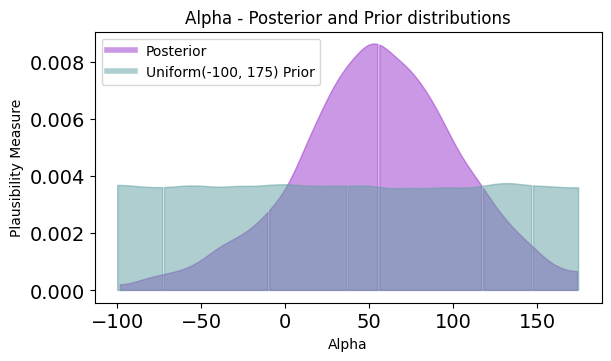

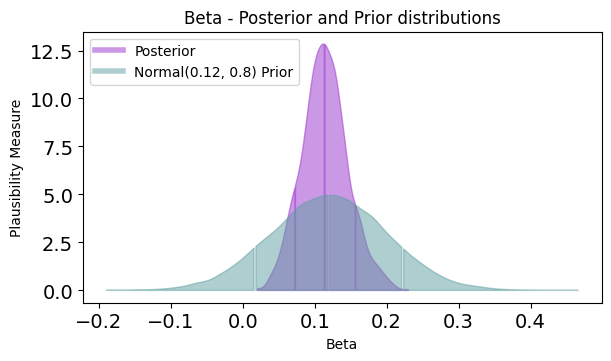

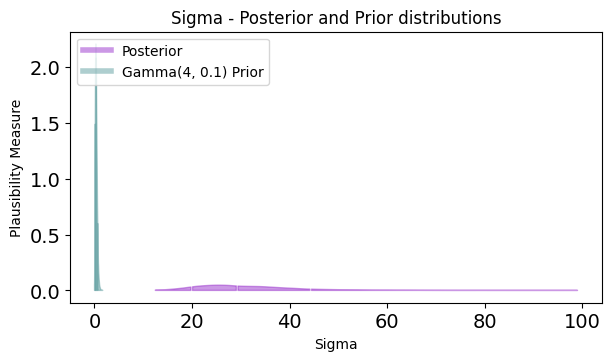

In [ ]:
# Alpha
plot_posterior_prior(drawsDS.alpha, np.random.default_rng().uniform(-100, 175, 50000),
                     'Alpha', 'Uniform(-100, 175) Prior')

# Beta
plot_posterior_prior(drawsDS.beta, np.random.default_rng().normal(0.12, 0.08, 50000),
                     'Beta', 'Normal(0.12, 0.8) Prior')

# Sigma
plot_posterior_prior(drawsDS.sigma, np.random.default_rng().gamma(4, 0.1, 50000),
                     'Sigma', 'Gamma(4, 0.1) Prior')

## Convergence of chains

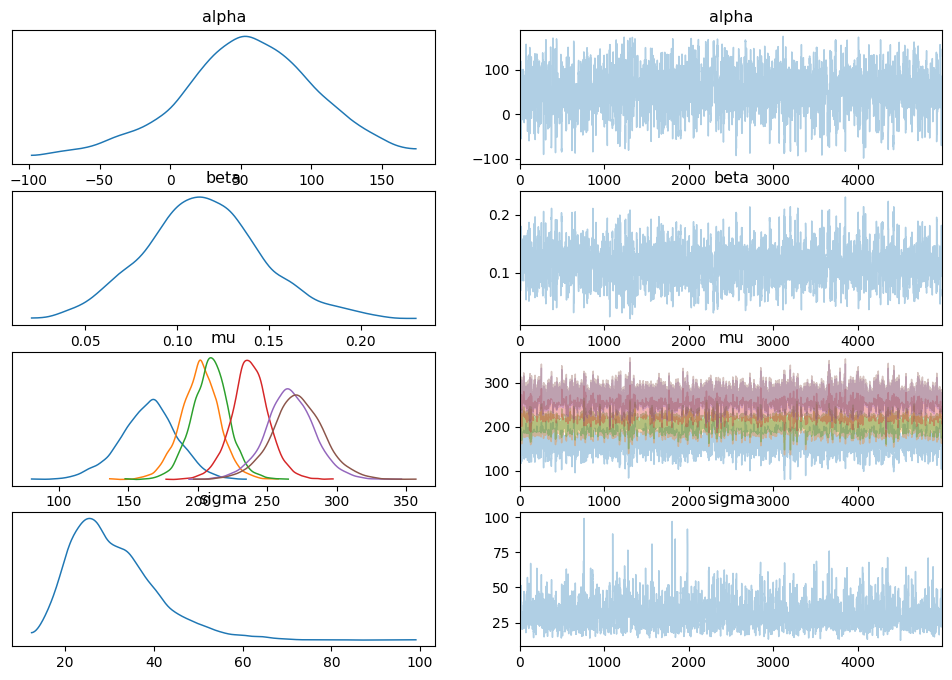

In [ ]:
# https://github.com/pyro-ppl/numpyro/issues/1241
az.plot_trace(az.from_numpyro(mcmc), compact=True)
plt.show()

# Hierarchical regression


In [ ]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro arviz

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
file_url = "https://gist.githubusercontent.com/ucals/2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/43034c39052dcf97d4b894d2ec1bc3f90f3623d9/osic_pulmonary_fibrosis.csv"
train = pd.read_csv(file_url)
train.head()

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker

In [ ]:
train.groupby('Patient')['Weeks'].count().sort_values(ascending=False).head(10)

Patient
ID00105637202208831864134    10
ID00119637202215426335765    10
ID00229637202260254240583    10
ID00140637202231728595149    10
ID00388637202301028491611    10
ID00400637202305055099402    10
ID00167637202237397919352    10
ID00343637202287577133798    10
ID00099637202206203080121    10
ID00421637202311550012437    10
Name: Weeks, dtype: int64

In [ ]:
train.shape

(1549, 9)

In [ ]:
print('Unique patients:', train['Patient'].nunique())

Unique patients: 176


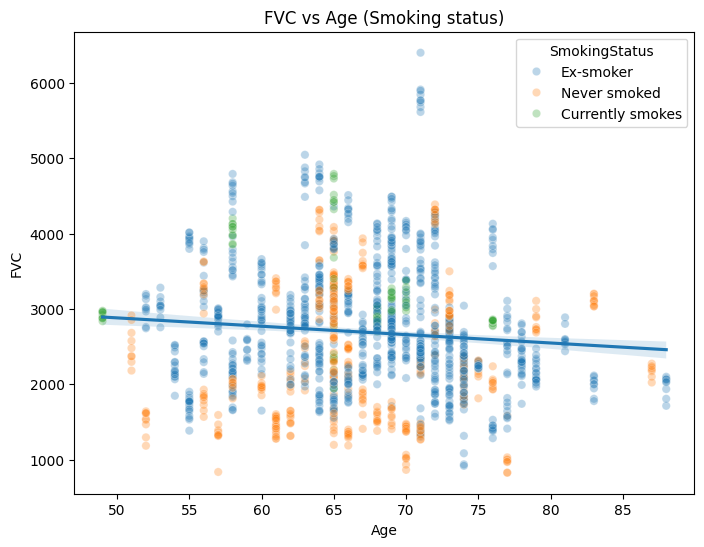

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(train, x='Age', y='FVC', ax=ax, scatter=False)
sns.scatterplot(train, x='Age', y='FVC', hue='SmokingStatus', ax=ax, alpha=0.3)
ax.set_title('FVC vs Age (Smoking status)')
plt.show()

In [ ]:
train.groupby(['Patient', 'SmokingStatus'])['Weeks'].count().sort_values(ascending=False).head(10)

Patient                    SmokingStatus   
ID00105637202208831864134  Ex-smoker           10
ID00119637202215426335765  Ex-smoker           10
ID00229637202260254240583  Ex-smoker           10
ID00140637202231728595149  Currently smokes    10
ID00388637202301028491611  Ex-smoker           10
ID00400637202305055099402  Ex-smoker           10
ID00167637202237397919352  Ex-smoker           10
ID00343637202287577133798  Never smoked        10
ID00099637202206203080121  Ex-smoker           10
ID00421637202311550012437  Ex-smoker           10
Name: Weeks, dtype: int64

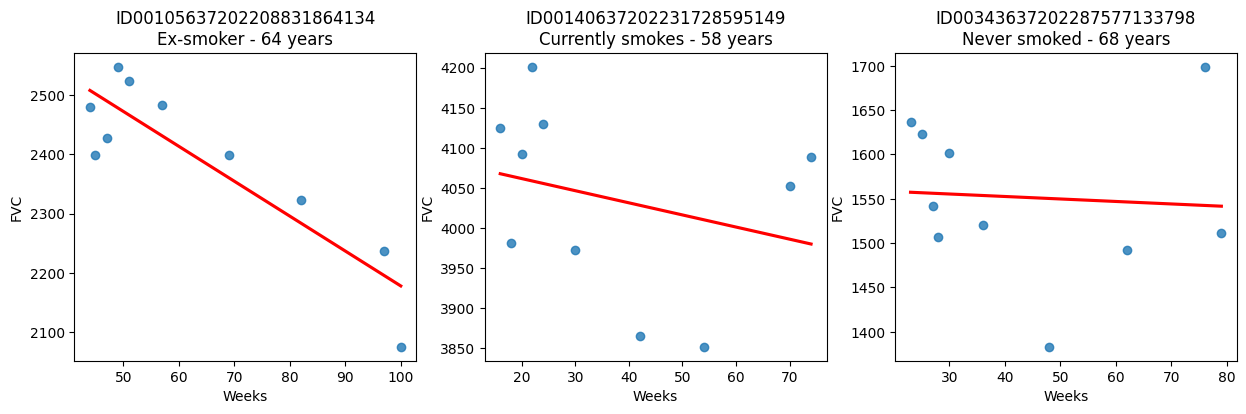

In [ ]:
def chart_patient(patient_id, ax):
    data = train[train["Patient"] == patient_id]
    x = data["Weeks"]
    y = data["FVC"]
    title = patient_id + '\n' + data['SmokingStatus'].unique()[0] + ' - ' + str(data['Age'].unique()[0]) + ' years'
    ax.set_title(title)
    sns.regplot(x=x, y=y, ax=ax, ci=None, line_kws={"color": "red"})


f, axes = plt.subplots(1, 3, figsize=(15, 4))
chart_patient("ID00105637202208831864134", axes[0])
chart_patient("ID00140637202231728595149", axes[1])
chart_patient("ID00343637202287577133798", axes[2])

In [ ]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
from jax import random
import arviz as az

from sklearn.preprocessing import LabelEncoder

In [ ]:
def model(patient_code, Weeks, FVC_obs=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 3.0))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(3.0))

    n_patients = len(np.unique(patient_code))

    with numpyro.plate("plate_i", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[patient_code] + β[patient_code] * Weeks

    with numpyro.plate("data", len(patient_code)):
        numpyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC_obs)


In [ ]:
patient_encoder = LabelEncoder()
train["patient_code"] = patient_encoder.fit_transform(train["Patient"].values)

FVC_obs = train["FVC"].values
Weeks = train["Weeks"].values
patient_code = train["patient_code"].values

In [ ]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, patient_code, Weeks, FVC_obs=FVC_obs)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [01:02<00:00, 64.42it/s, 63 steps of size 1.04e-02. acc. prob=0.84] 


In [ ]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      α[0]   2183.34     64.59   2183.10   2075.64   2286.07   3401.97      1.00
      α[1]   3783.08     73.27   3782.29   3658.10   3898.74   2145.61      1.00
      α[2]   3266.85     58.93   3267.21   3172.19   3363.43   2106.26      1.00
      α[3]   3478.11     67.07   3477.27   3369.81   3586.72   2179.57      1.00
      α[4]   3703.15    121.84   3699.90   3527.14   3915.52   4275.60      1.00
      α[5]   3723.10     60.99   3722.92   3616.08   3814.93   1625.62      1.00
      α[6]   3050.74     92.41   3050.08   2900.52   3200.93   3359.89      1.00
      α[7]   2150.62     76.93   2148.72   2030.98   2282.33   4425.59      1.00
      α[8]   2342.82     89.07   2341.00   2205.28   2491.10   4123.07      1.00
      α[9]   1495.25     58.28   1495.65   1398.89   1590.23   4045.74      1.00
     α[10]   3149.00     58.33   3149.87   3061.47   3252.13   2069.54      1.00
     α[11]   3060.29    134

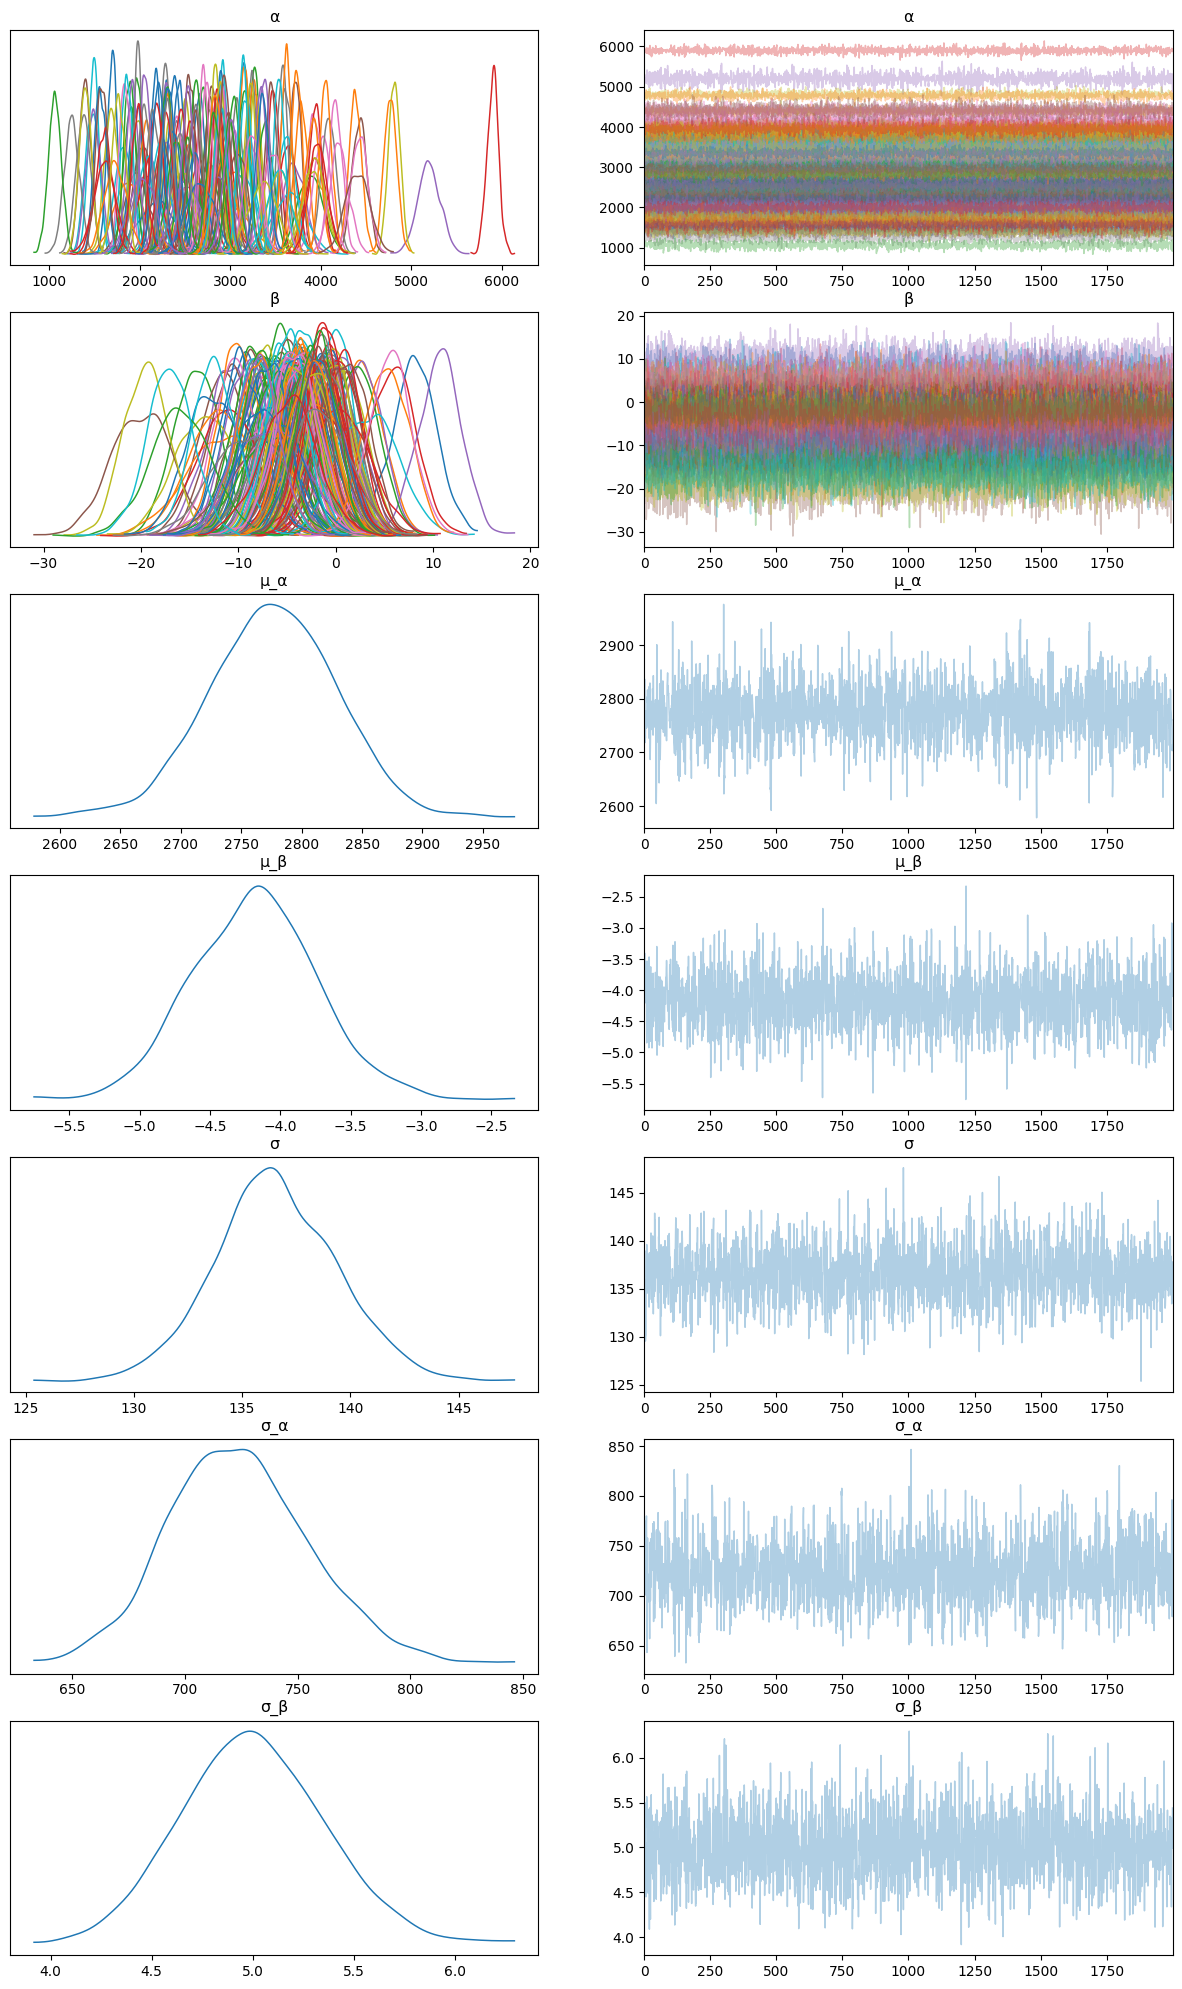

In [ ]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 25));

In [ ]:
def create_prediction_template(unique_patient_df, weeks_series):
    unique_patient_df["_temp"] = True
    weeks = pd.DataFrame(weeks_series, columns=["Weeks"])
    weeks["_temp"] = True
    return unique_patient_df.merge(weeks, on="_temp").drop(["_temp"], axis=1)

In [ ]:
patients = train[["Patient", "patient_code"]].drop_duplicates()
start_week_number = -12
end_week_number = 134
predict_weeks = pd.Series(np.arange(start_week_number, end_week_number))
pred_template = create_prediction_template(patients, predict_weeks)

In [ ]:
patient_code = pred_template["patient_code"].values
Weeks = pred_template["Weeks"].values
predictive = Predictive(model, posterior_samples, return_sites=["σ", "obs"])
samples_predictive = predictive(random.PRNGKey(0), patient_code, Weeks, None)

In [ ]:
df = pred_template.copy()
df["FVC_pred"] = samples_predictive["obs"].T.mean(axis=1)
df["sigma"] = samples_predictive["obs"].T.std(axis=1)
df["FVC_inf"] = df["FVC_pred"] - df["sigma"]
df["FVC_sup"] = df["FVC_pred"] + df["sigma"]
df = pd.merge(
    df, train[["Patient", "Weeks", "FVC"]], how="left", on=["Patient", "Weeks"]
)
df = df.rename(columns={"FVC": "FVC_true"})
df.shape

(25703, 8)

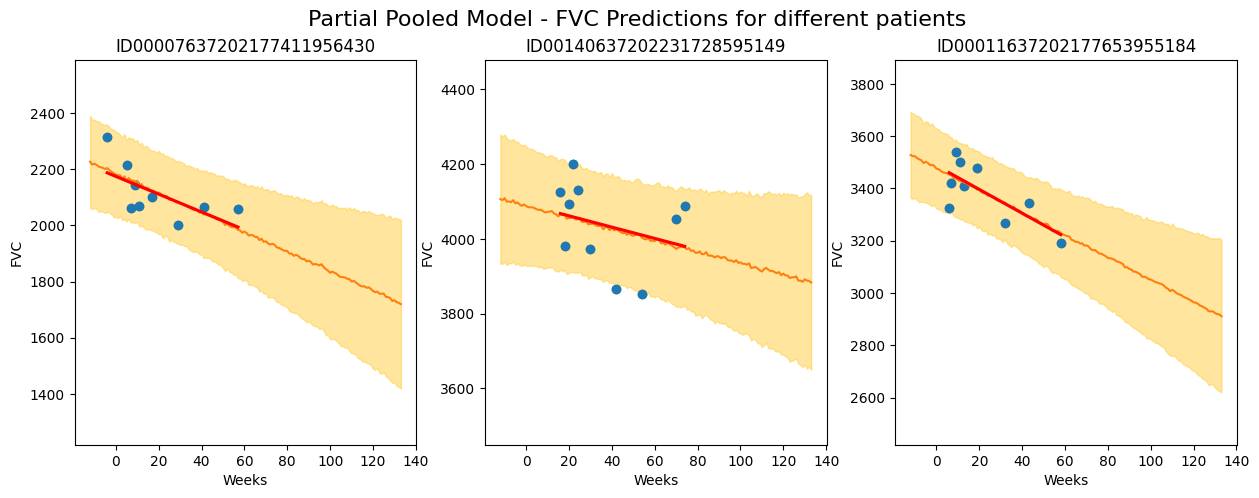

In [ ]:
def chart_patient_with_predictions(patient_id, ax):
    data = df[df["Patient"] == patient_id]
    x = data["Weeks"]
    ax.set_title(patient_id)
    ax.plot(x, data["FVC_true"], "o")
    ax.plot(x, data["FVC_pred"])
    #ax.set_ylim((1400, 4400))
    ax.set_ylim((data["FVC_inf"].min()-200, data["FVC_sup"].max()+200))
    ax = sns.regplot(x=x, y=data["FVC_true"], ax=ax, ci=None, line_kws={"color": "red"})
    ax.fill_between(x, data["FVC_inf"], data["FVC_sup"], alpha=0.5, color="#ffcd3c")
    ax.set_ylabel("FVC")


f, axes = plt.subplots(1, 3, figsize=(15, 5))
f.suptitle("Partial Pooled Model - FVC Predictions for different patients", fontsize=16)
chart_patient_with_predictions("ID00007637202177411956430", axes[0])
chart_patient_with_predictions("ID00140637202231728595149", axes[1])
chart_patient_with_predictions("ID00011637202177653955184", axes[2])

# Add Smooking status

In [ ]:
train["SmokingStatus"].value_counts()

patient_code = train["patient_code"].values
Weeks = train["Weeks"].values

smoking_status_encoder = LabelEncoder()
train["smoking_status_code"] = smoking_status_encoder.fit_transform(
    train["SmokingStatus"]
)

smoking_status_code = train["smoking_status_code"].values

In [ ]:
map_patient_to_smoking_status = (
    train[["patient_code", "smoking_status_code"]]
    .drop_duplicates()
    .set_index("patient_code", verify_integrity=True)
    .sort_index()["smoking_status_code"]
    .values
)

In [ ]:
def model_smoking_hierarchy(
    patient_code, Weeks, map_patient_to_smoking_status, FVC_obs=None
):
    μ_α_global = numpyro.sample("μ_α_global", dist.Normal(0.0, 500.0))
    σ_α_global = numpyro.sample("σ_α_global", dist.HalfNormal(100.0))
    μ_β_global = numpyro.sample("μ_β_global", dist.Normal(0.0, 3.0))
    σ_β_global = numpyro.sample("σ_β_global", dist.HalfNormal(3.0))

    n_patients = len(np.unique(patient_code))
    n_smoking_statuses = len(np.unique(map_patient_to_smoking_status))

    with numpyro.plate("plate_smoking_status", n_smoking_statuses):
        μ_α_smoking_status = numpyro.sample(
            "μ_α_smoking_status", dist.Normal(μ_α_global, σ_α_global)
        )
        μ_β_smoking_status = numpyro.sample(
            "μ_β_smoking_status", dist.Normal(μ_β_global, σ_β_global)
        )

    with numpyro.plate("plate_i", n_patients):
        α = numpyro.sample(
            "α",
            dist.Normal(μ_α_smoking_status[map_patient_to_smoking_status], σ_α_global),
        )
        β = numpyro.sample(
            "β",
            dist.Normal(μ_β_smoking_status[map_patient_to_smoking_status], σ_β_global),
        )

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[patient_code] + β[patient_code] * Weeks

    with numpyro.plate("data", len(patient_code)):
        numpyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC_obs)

In [ ]:
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

reparam_config = {
    "μ_α_smoking_status": LocScaleReparam(0),
    "μ_β_smoking_status": LocScaleReparam(0),
    "α": LocScaleReparam(0),
    "β": LocScaleReparam(0),
}
reparam_model_smoking_hierarchy = reparam(
    model_smoking_hierarchy, config=reparam_config
)

In [ ]:
nuts_kernel = NUTS(reparam_model_smoking_hierarchy, target_accept_prob=0.97)

mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=5000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, patient_code, Weeks, map_patient_to_smoking_status, FVC_obs=FVC_obs)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 8000/8000 [04:54<00:00, 27.14it/s, 1023 steps of size 5.62e-03. acc. prob=0.97]


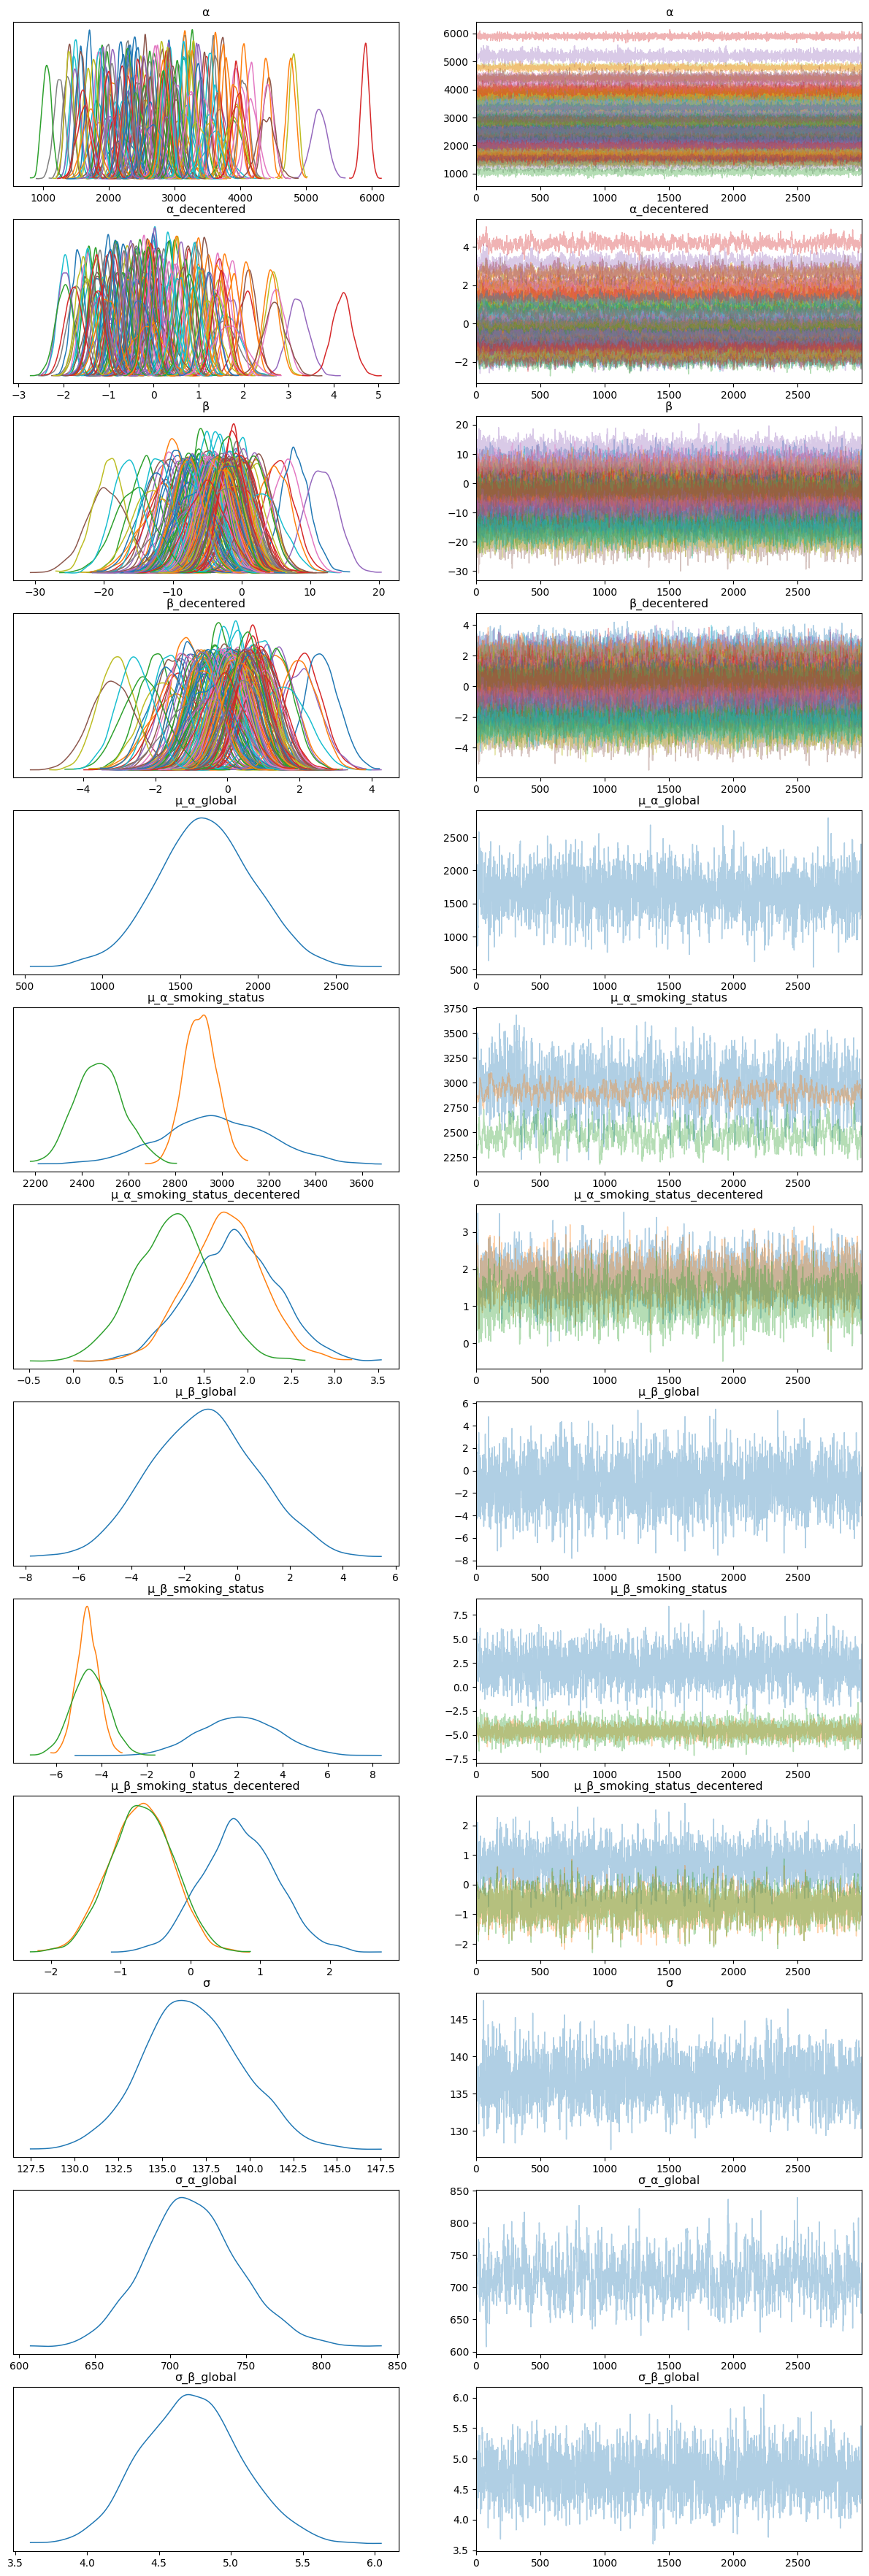

In [ ]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 45));

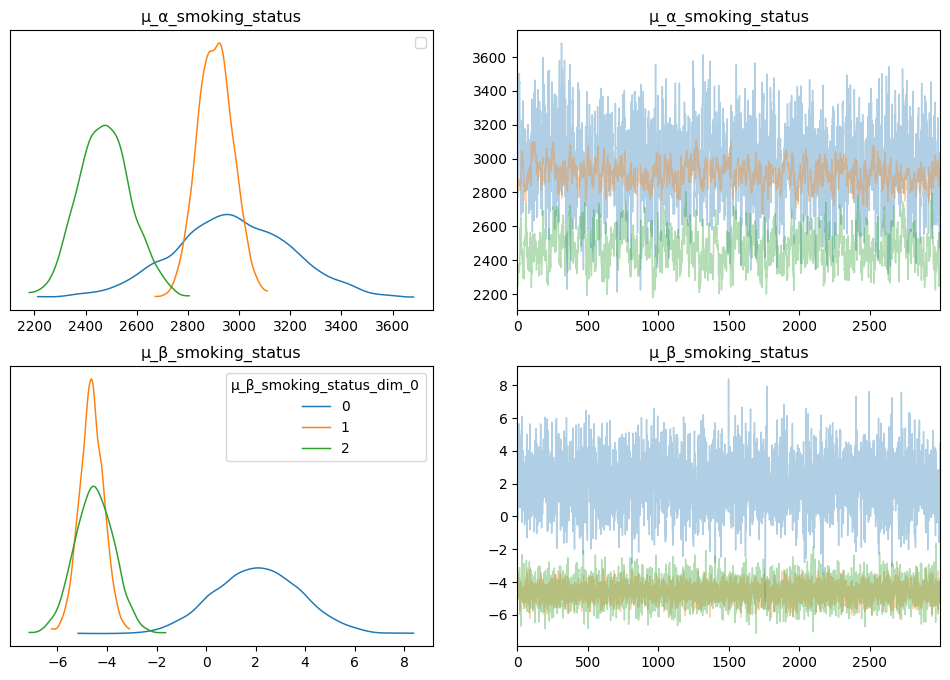

In [ ]:
axes = az.plot_trace(
    data,
    var_names=["μ_α_smoking_status", "μ_β_smoking_status"],
    legend=True,
    compact=True,
    figsize=(12, 8),
)
# The legend handles were not working for the first plot
axes[0, 0].legend();

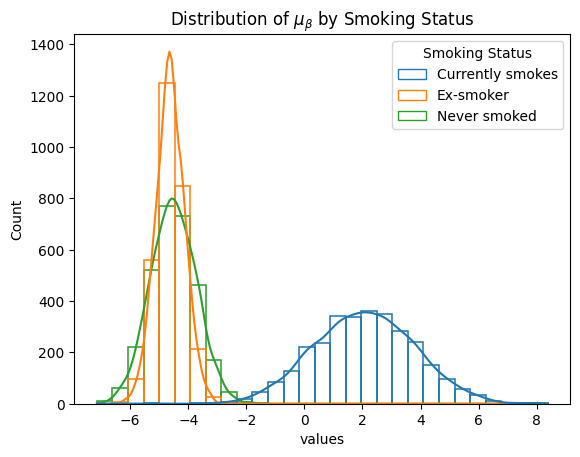

In [ ]:
data_ = np.array(data.posterior.μ_β_smoking_status)[0]

all_data = pd.DataFrame({'Smoking Status': "Currently smokes", 'values': data_[:,0]})
all_data = pd.concat([all_data, pd.DataFrame({'Smoking Status': "Ex-smoker", 'values': data_[:,1]})], axis='rows')
all_data = pd.concat([all_data, pd.DataFrame({'Smoking Status': "Never smoked", 'values': data_[:,2]})], axis='rows')

sns.histplot(all_data, hue='Smoking Status', x='values', kde=True, fill=False)
plt.title(r'Distribution of $\mu_{\beta}$ by Smoking Status')
plt.show()

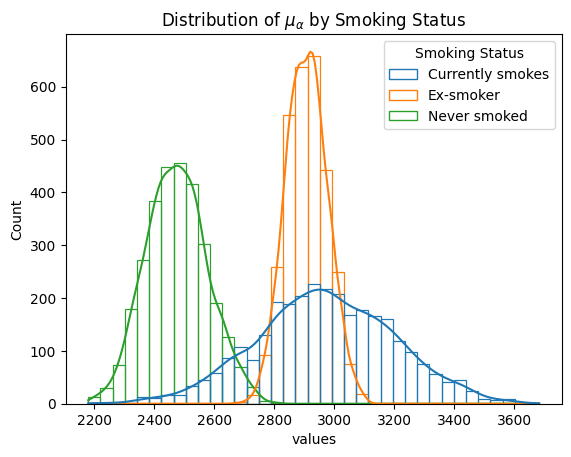

In [ ]:
data_ = np.array(data.posterior.μ_α_smoking_status)[0]

all_data = pd.DataFrame({'Smoking Status': "Currently smokes", 'values': data_[:,0]})
all_data = pd.concat([all_data, pd.DataFrame({'Smoking Status': "Ex-smoker", 'values': data_[:,1]})], axis='rows')
all_data = pd.concat([all_data, pd.DataFrame({'Smoking Status': "Never smoked", 'values': data_[:,2]})], axis='rows')

sns.histplot(all_data, hue='Smoking Status', x='values', kde=True, fill=False)
plt.title(r'Distribution of $\mu_{\alpha}$ by Smoking Status')
plt.show()

In [ ]:
trace = az.from_numpyro(mcmc)
az.summary(
    trace,
    var_names=["μ_α_global", "μ_β_global", "μ_α_smoking_status", "μ_β_smoking_status"],
)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)


mean       sd    hdi_3%   hdi_97%  mcse_mean  \
μ_α_global             1660.319  309.353  1120.261  2271.491      6.672   
μ_β_global               -1.251    2.058    -5.012     2.657      0.038   
μ_α_smoking_status[0]  2970.166  227.237  2569.839  3427.068      7.738   
μ_α_smoking_status[1]  2907.338   68.203  2779.935  3031.105      5.328   
μ_α_smoking_status[2]  2474.675  102.584  2279.913  2663.601      6.258   
μ_β_smoking_status[0]     2.070    1.716    -1.081     5.269      0.033   
μ_β_smoking_status[1]    -4.623    0.496    -5.566    -3.675      0.010   
μ_β_smoking_status[2]    -4.513    0.787    -5.983    -3.025      0.016   

                       mcse_sd  ess_bulk  ess_tail  r_hat  
μ_α_global               4.723    2147.0    2069.0    NaN  
μ_β_global               0.035    2908.0    1910.0    NaN  
μ_α_smoking_status[0]    5.501     858.0    1386.0    NaN  
μ_α_smoking_status[1]    3.782     165.0     295.0    NaN  
μ_α_smoking_status[2]    4.436     270.0     534.0    NaN  
μ_β_smoking_status[0]    0.025    2702.0    2221.0    NaN  
μ_β_smoking_status[1]    0.007    2345.0    2576.0    NaN  
μ_β_smoking_status[2]    0.011    2444.0    2537.0    NaN

In [ ]:
patient_code = pred_template["patient_code"].values
Weeks = pred_template["Weeks"].values
predictive = Predictive(
    reparam_model_smoking_hierarchy, posterior_samples, return_sites=["σ", "obs"]
)
samples_predictive = predictive(
    random.PRNGKey(0), patient_code, Weeks, map_patient_to_smoking_status, None
)

In [ ]:
df = pred_template.copy()
df["FVC_pred"] = samples_predictive["obs"].T.mean(axis=1)
df["sigma"] = samples_predictive["obs"].T.std(axis=1)
df["FVC_inf"] = df["FVC_pred"] - df["sigma"]
df["FVC_sup"] = df["FVC_pred"] + df["sigma"]
df = pd.merge(
    df, train[["Patient", "Weeks", "FVC"]], how="left", on=["Patient", "Weeks"]
)
df = df.rename(columns={"FVC": "FVC_true"})
df.head()

Patient  patient_code  Weeks     FVC_pred       sigma  \
0  ID00007637202177411956430             0    -12  2228.808594  158.073898   
1  ID00007637202177411956430             0    -11  2224.735352  157.755127   
2  ID00007637202177411956430             0    -10  2224.209961  155.682312   
3  ID00007637202177411956430             0     -9  2212.502197  155.275085   
4  ID00007637202177411956430             0     -8  2218.909912  155.820572   

       FVC_inf      FVC_sup  FVC_true  
0  2070.734619  2386.882568       NaN  
1  2066.980225  2382.490479       NaN  
2  2068.527588  2379.892334       NaN  
3  2057.227051  2367.777344       NaN  
4  2063.089355  2374.730469       NaN

In [ ]:
def chart_patient_with_predictions_(patient_id, ax):
    data = df[df["Patient"] == patient_id]

    x = data["Weeks"]
    age = train.query(f'Patient == "{patient_id}"')['Age'].unique()[0]
    smoking_status = train.query(f'Patient == "{patient_id}"')['SmokingStatus'].unique()[0]

    title = patient_id + '\n' + str(smoking_status) + ' - ' + str(age) + ' years'
    ax.set_title(title)
    ax.plot(x, data["FVC_true"], "o")
    ax.plot(x, data["FVC_pred"])
    #ax.set_ylim((1400, 4400))
    ax.set_ylim((data["FVC_inf"].min()-200, data["FVC_sup"].max()+200))
    ax = sns.regplot(x=x, y=data["FVC_true"], ax=ax, ci=None, line_kws={"color": "red"})
    ax.fill_between(x, data["FVC_inf"], data["FVC_sup"], alpha=0.5, color="#ffcd3c")

    ax.set_ylabel("FVC")
    ax.set_xlabel("")


In [ ]:
train.query('Age < 50')

Patient  Weeks   FVC     Percent  Age     Sex  \
288  ID00082637202201836229724     19  2918   99.794802   49  Female   
289  ID00082637202201836229724     27  2955  101.060192   49  Female   
290  ID00082637202201836229724     29  2873   98.255814   49  Female   
291  ID00082637202201836229724     31  2963  101.333789   49  Female   
292  ID00082637202201836229724     33  2885   98.666211   49  Female   
293  ID00082637202201836229724     39  2837   97.024624   49  Female   
294  ID00082637202201836229724     51  2975  101.744186   49  Female   
295  ID00082637202201836229724     63  2957  101.128591   49  Female   
296  ID00082637202201836229724     79  2875   98.324213   49  Female   

        SmokingStatus  patient_code  smoking_status_code  
288  Currently smokes            33                    0  
289  Currently smokes            33                    0  
290  Currently smokes            33                    0  
291  Currently smokes            33                    0  
292  Currently smokes            33                    0  
293  Currently smokes            33                    0  
294  Currently smokes            33                    0  
295  Currently smokes            33                    0  
296  Currently smokes            33                    0

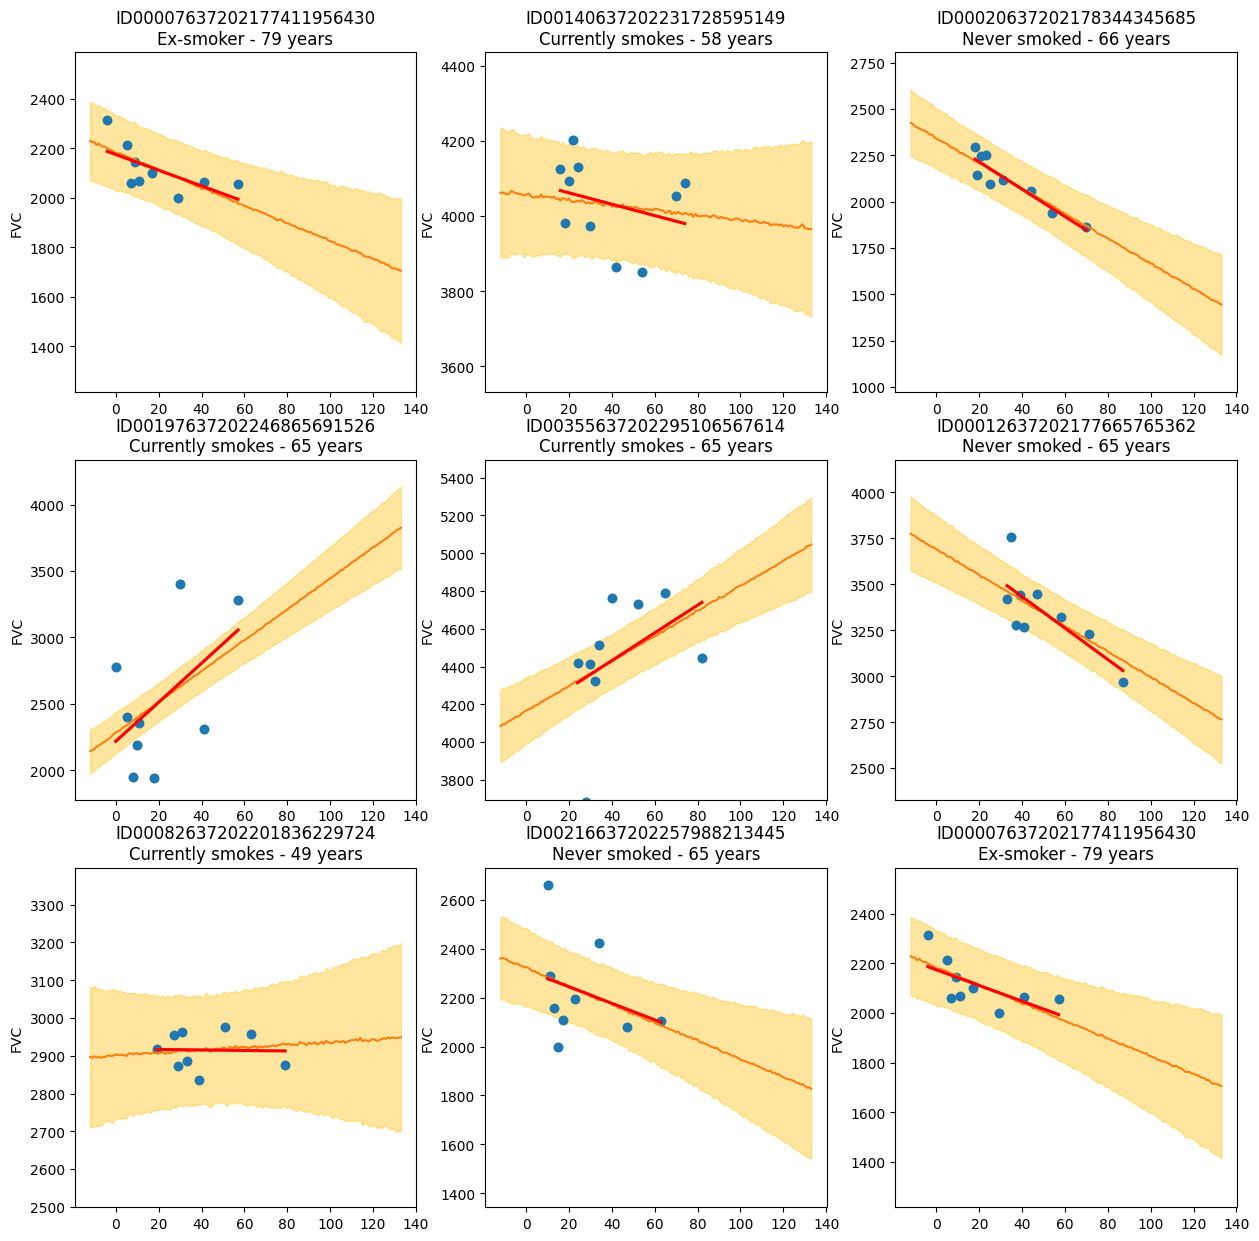

In [ ]:
f, axes = plt.subplots(3, 3, figsize=(15, 15))

patients = ["ID00007637202177411956430", "ID00140637202231728595149", "ID00020637202178344345685",
            "ID00197637202246865691526", "ID00355637202295106567614", "ID00012637202177665765362",
            "ID00082637202201836229724", "ID00216637202257988213445", "ID00007637202177411956430"
]
for i, patient in enumerate(patients):
    chart_patient_with_predictions_(patient, axes.flatten()[i])